# Task:
# Topic 8: Defining an effective boundary and a set of optimal portfolios

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

import apimoex
import requests

import site
print(*site.getsitepackages()) 
print(site.getusersitepackages())

C:\PROGRAMS\Anaconda C:\PROGRAMS\Anaconda\lib\site-packages
C:\Users\Илья\AppData\Roaming\Python\Python39\site-packages


# Параметры

In [2]:
interval = 24
index_moex = ['AFKS','AFLT','ALRS','CBOM','CHMF',
                'DSKY','ENPG','FIVE','FIXP','GAZP',
                'GLTR','GMKN','HYDR','IRAO',
                'LKOH','MAGN','MGNT','MOEX','MTSS',
                'NLMK','NVTK','OZON','PHOR','PIKK',
                'PLZL','POLY','ROSN','RTKM','RUAL',
                'SBER','SBERP','SNGS','SNGSP','TATN',
                'TATNP','TCSG','TRNFP','VKCO','VTBR','YNDX']

In [3]:
session = requests.Session()
for symbol in index_moex:
    data = apimoex.get_market_candles(session,symbol,interval=interval)
    df = pd.DataFrame(data)
    if len(df)<100:
        print(f'{symbol}')
        input('The length of the frame with the symbol is less than 100. Continue?')
    df.to_excel(f'{symbol}_{interval}.xlsx')

# Парсинг котировок

In [3]:
stock_dict={}
for symbol in index_moex:
    df = pd.read_excel(f'{symbol}_{interval}.xlsx')
    df['begin'] = df['begin'].apply(lambda x: str(x)[:10])
    df['time'] = pd.to_datetime(df['begin'], format = '%Y-%m-%d')
    stock_dict[symbol]=df[['time','open','high','low','close','value']]

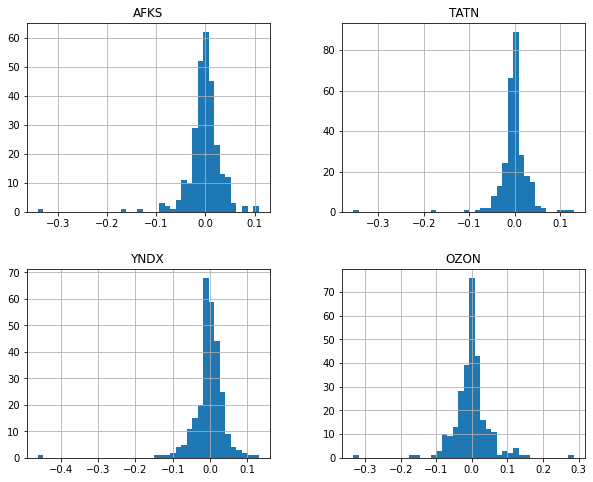

In [4]:
stock_dict_ = stock_dict.copy()
for k,v in stock_dict_.items():
    new_df = pd.DataFrame(columns=[k])
    v.index = v['time']
    new_df[k] = v['close']
    stock_dict_[k] = new_df

raw_quotes = pd.concat([df for df in stock_dict_.values()], axis=1, join='inner')

log_returns = np.log(raw_quotes/raw_quotes.shift(1))
log_returns = log_returns.iloc[1:]
raw_data = log_returns.copy() 

In [7]:
len(raw_data)

277

# Function for building all possible sets of portfolios

['AFKS', 'AFLT', 'ALRS', 'CBOM', 'CHMF', 'DSKY', 'ENPG', 'FIVE', 'FIXP', 'GAZP', 'GLTR', 'GMKN', 'HYDR', 'IRAO', 'LKOH', 'MAGN', 'MGNT', 'MOEX', 'MTSS', 'NLMK', 'NVTK', 'OZON', 'PHOR', 'PIKK', 'PLZL', 'POLY', 'ROSN', 'RTKM', 'RUAL', 'SBER', 'SBERP', 'SNGS', 'SNGSP', 'TATN', 'TATNP', 'TCSG', 'TRNFP', 'VKCO', 'VTBR', 'YNDX']


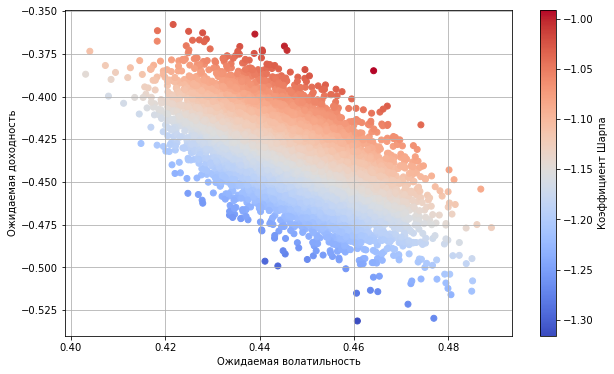

In [13]:
rf = 0.075

def marcowitz(log_returns, symbols, limit_1 = None, limit_2=None, iterations = 10000):
    print(symbols)
    
    data = log_returns[symbols]
    if limit_1 is not None or limit_2 is not None:
        data = data.iloc[limit_1:limit_2]
        
    def port_ret(weights) :
        return np.sum(data.mean()*weights)*252
    
    def port_vol(weights) :
        return np.sqrt(np.dot(weights.T,np.dot(data.cov()*252,weights)))

    prets = []
    pvols = []

    for p in range(iterations):
        weights = np.random.random(len(data.columns))
        weights = weights/np.sum(weights)
        prets.append(port_ret(weights))
        pvols.append(port_vol(weights))

    prets = np.array(prets)
    pvols = np.array(pvols)

    plt.figure(figsize=(10,6))
    plt.scatter(pvols,
                prets, 
                c=(prets-rf)/pvols,
                marker='o', 
                cmap='coolwarm')
    plt.grid()
    plt.xlabel('Ожидаемая волатильность')
    plt.ylabel('Ожидаемая доходность')
    plt.colorbar(label='Коэффициент Шарпа')
    
    return data, prets, pvols
    
# symbols = random.sample(index_moex,4)
symbols = index_moex
data, prets, pvols = marcowitz(log_returns, symbols)

# Realization of a portfolio with low-correlating assets

Длина фрейма = 277
Index(['GLTR', 'MAGN', 'PHOR', 'VTBR'], dtype='object')


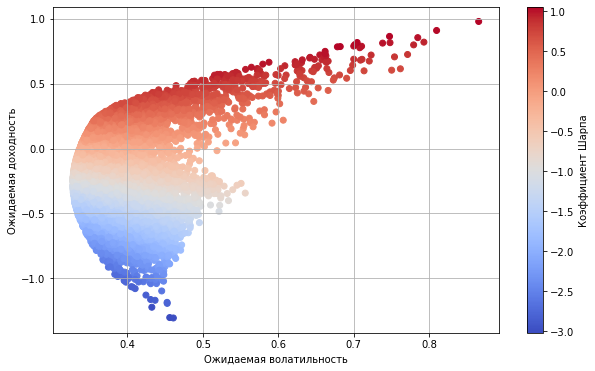

In [32]:
print(f'Длина фрейма = {len(log_returns)}')

corr = log_returns.corr()
filtered_corr = corr[((corr >= -0.04) & (corr <= +0.04)) & (corr !=1.000)]

for column in filtered_corr.columns:
    if filtered_corr[column].isna().sum() == len(filtered_corr):
        filtered_corr=filtered_corr.drop(column, axis=1)
        filtered_corr=filtered_corr.drop(column)
        
symbols = filtered_corr.columns
data, prets, pvols  = marcowitz(log_returns, 
                                  symbols,
                                  limit_1 = 50,
                                  limit_2 = 150,
                                  iterations = 10000)
#50 - 100

# Finding extreme values of profitability and volatility

     fun: -1.1731827118172755
     jac: array([ 3.70263755e-02,  1.60689829e+00,  1.16169453e-04, -6.35847449e-04])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([8.23993651e-17, 0.00000000e+00, 8.45503541e-01, 1.54496459e-01])


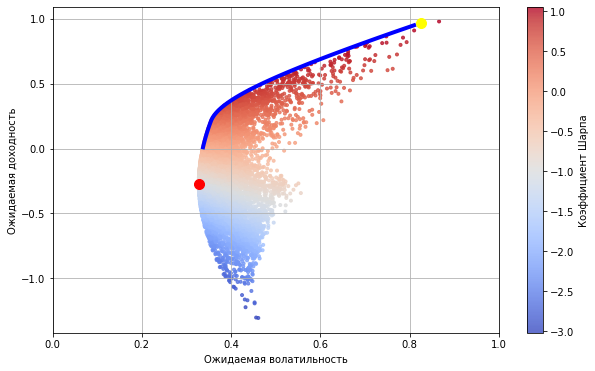

In [52]:
#==================================== optimization
import scipy.optimize as sco

def port_ret(weights) :
    return np.sum(data.mean()*weights)*252
    
def port_vol(weights) :
    return np.sqrt(np.dot(weights.T,np.dot(data.cov()*252,weights)))

def min_func_sharpe(weights):
    return -port_ret(weights)/port_vol(weights)

cons = ({'type' : 'eq', 'fun' : lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(len(symbols)))

eweights = np.array(len(symbols)*[1./len(symbols),])

opts = sco.minimize(min_func_sharpe,eweights,method='SLSQP', bounds=bnds,constraints=cons)
optv = sco.minimize(port_vol,eweights,method='SLSQP', bounds=bnds,constraints=cons)

# -------------------------------------------------------------------------

cons = ({'type': 'eq', 'fun' : lambda x: port_ret(x) - tret},
        {'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})

bnds = tuple((0,1) for x in eweights)
trets = np.linspace(0.01, 0.95, 50) 

tvols = []
for tret in trets:
    res = sco.minimize(port_vol,
                       eweights,
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

plt.figure(figsize=(10, 6))
plt.scatter(pvols, 
            prets, 
            c=(prets-rf)/pvols,
            marker= '.', 
            alpha=0.8, 
            cmap= 'coolwarm' )
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']),'o', markersize= 10.0,color='yellow')
plt.plot(port_vol(optv['x']), port_ret(optv['x']),'o', markersize=10.0,color='red')
plt.grid()
plt.xlim((0, 1))
plt.xlabel('Ожидаемая волатильность')
plt.ylabel('Ожидаемая доходность')
plt.colorbar(label='Коэффициент Шарпа')

print(opts)

# Adding a capital curve

C:\PROGRAMS\Anaconda\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


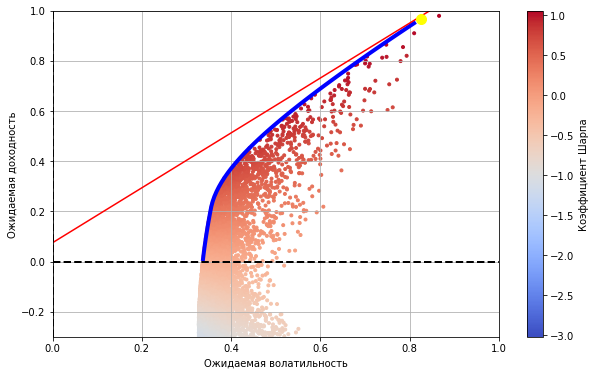

In [59]:
import scipy.interpolate as sci

rf = 0.075

ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]
tck = sci.splrep(evols,erets)

def f(x):
    return sci.splev(x,tck,der=0)

def df(x):
    return sci.splev(x, tck, der= 1)

def equations(p, rf=rf):
    eq1 = rf - p[0] 
    eq2 = rf + p[1]*p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [rf,0.55,0.15])

plt.figure(figsize = (10, 6))
plt.scatter(pvols, 
            prets, 
            c = (prets - rf)/pvols,
            marker = '.', 
            cmap = 'coolwarm')

plt.plot(evols, erets, 'b', lw=4.0)

cx = np.linspace(0.0,1)
#plt.plot(cx, opt[0]+opt[1]*cx, 'r', lw=1.5)
plt.plot([0,opt[2]], [rf,f(opt[2])], 'r', lw=1.5)

#plt.plot(opt[2], f(opt[2]), 'o', markersize=10.0,color='yellow')
plt.plot(port_vol(opts['x']), port_ret(opts['x']),'o', markersize= 10.0,color='yellow')
plt.grid(True)
plt.axhline(0, color= 'k', ls= '--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('Ожидаемая волатильность')
plt.ylabel('Ожидаемая доходность')
plt.xlim((0, 1))
plt.ylim((-0.3, 1))
plt.colorbar(label= 'Коэффициент Шарпа')